In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from estimation_fct import *

# Load model
from model import ModelClass

model = ModelClass() 

par = model.par
sol = model.sol
sim = model.sim


c:\Users\Peter\Design_retirement\model.py:135: RuntimeWarning: invalid value encountered in divide
  np.cumsum(S[::-1])[::-1] / S,


In [2]:
model.solve()
model.simulate()

In [3]:
# Prepare data
mean, weights, moments = prepare_data(par)

In [4]:
rows_to_drop = np.arange(40+70+55, 40+70+55+15)
cols_to_drop = np.arange(40+70+55, 40+70+55+15)

mean_drop = np.delete(mean, rows_to_drop, axis=0)

weights_drop = np.delete(weights, rows_to_drop, axis=0)
weights_drop = np.delete(weights_drop, cols_to_drop, axis=1)


In [5]:
var1 = np.mean(mean[:40])
var2 = np.mean(mean[40:110])
var3 = np.mean(mean[110:165])
var4 = np.mean(mean[180:])

n = 205
test_weight = np.zeros((n, n))

# fill only the four blocks with 1/var^2
blocks = [
    (0,    40,  var1),
    (40,  110,  var2),
    (110, 165,  var3),
    (180, 205,  var4)
]

for start, end, v in blocks:
    idx = np.arange(start, end)
    test_weight[idx, idx] = 1.0 / (v**2)


In [6]:
# Prepare SMM
theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "r_a", "r_s")
theta_init = np.array([ 0.9333583 ,  1.09681432,  5.83268576,  6.52012549, 10.37613159,
        0.06849984,  0.01782551])

# Original bounds
orig_bounds = [(0.0, 1.0),   # beta
               (0.1, 6.0),   # sigma
               (0.1, 10.0),  # gamma
               (0.0, 15.0),  # mu
               (0.0, 15.0),  # zeta
               (0.001, 0.1),   # r_a_in
               (0.001, 0.1 )
               ] 

theta_init_scaled = scale_params(theta_init, orig_bounds)

In [7]:
# Do SMM
objective = lambda theta: obj_func(theta, theta_names, mean_drop, test_weight, model, orig_bounds, do_print=True)

res = minimize(
    objective, 
    theta_init_scaled,
    method='Nelder-Mead',
    bounds=[(0,1)] * len(theta_init_scaled),
    tol=1e-6,
    options={"maxiter":1000}
)


beta=0.933 sigma=1.097 gamma=5.833 mu=6.520 zeta=10.376 r_a=0.068 r_s=0.018 
Error = 1.84, Time = 22.0992 seconds
beta=0.980 sigma=1.097 gamma=5.833 mu=6.520 zeta=10.376 r_a=0.068 r_s=0.018 
Error = 2097.15, Time = 22.3422 seconds
beta=0.933 sigma=1.147 gamma=5.833 mu=6.520 zeta=10.376 r_a=0.068 r_s=0.018 
Error = 8.24, Time = 22.3893 seconds
beta=0.933 sigma=1.097 gamma=6.119 mu=6.520 zeta=10.376 r_a=0.068 r_s=0.018 
Error = 1.88, Time = 22.1924 seconds
beta=0.933 sigma=1.097 gamma=5.833 mu=6.846 zeta=10.376 r_a=0.068 r_s=0.018 
Error = 1.90, Time = 22.1323 seconds
beta=0.933 sigma=1.097 gamma=5.833 mu=6.520 zeta=10.895 r_a=0.068 r_s=0.018 
Error = 1.85, Time = 22.3205 seconds
beta=0.933 sigma=1.097 gamma=5.833 mu=6.520 zeta=10.376 r_a=0.072 r_s=0.018 
Error = 2.53, Time = 22.0654 seconds
beta=0.933 sigma=1.097 gamma=5.833 mu=6.520 zeta=10.376 r_a=0.068 r_s=0.019 
Error = 1.87, Time = 22.2947 seconds
beta=0.887 sigma=1.111 gamma=5.915 mu=6.613 zeta=10.524 r_a=0.069 r_s=0.018 
Error = 

In [8]:
# Load the model with calibrated values
theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "r_a", "r_s")
# theta_final = np.array([0.991, 1.126, 7.350, 9.986, 10.0, 0.7, 1.1 ])
theta_final = unscale_params(res.x, orig_bounds)
# theta_final = np.array([0.961, 1.127, 2.645, 6.657, 0.009, 0.041])
# theta_final = np.array([9.33727108e-01, 1.11070508e+00, 4.60048114e+00, 6.5    7.4, 7.00022874e-02, 15.99642707e-03])

# for i, name in enumerate(theta_names):
#     setattr(model.par, name, theta_final[i])

model.solve()
model.simulate()

In [9]:
theta_final

array([ 0.93569755,  1.08535175,  5.19848937,  6.21983447, 12.1366814 ,
        0.06775081,  0.01897517])

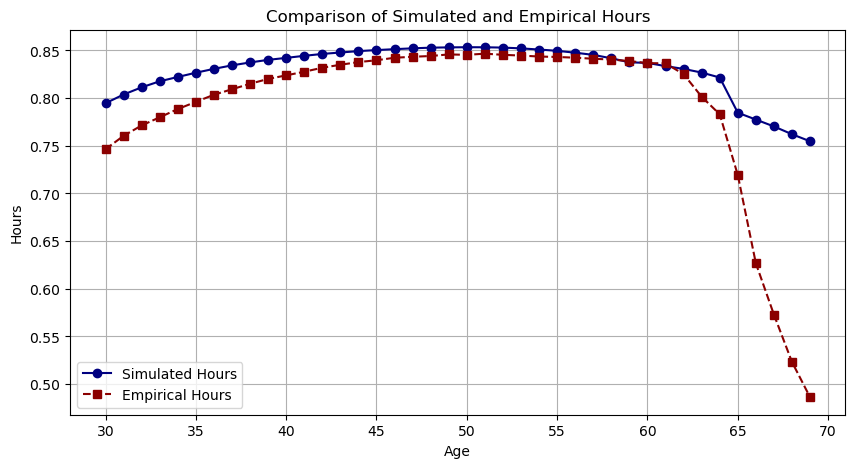

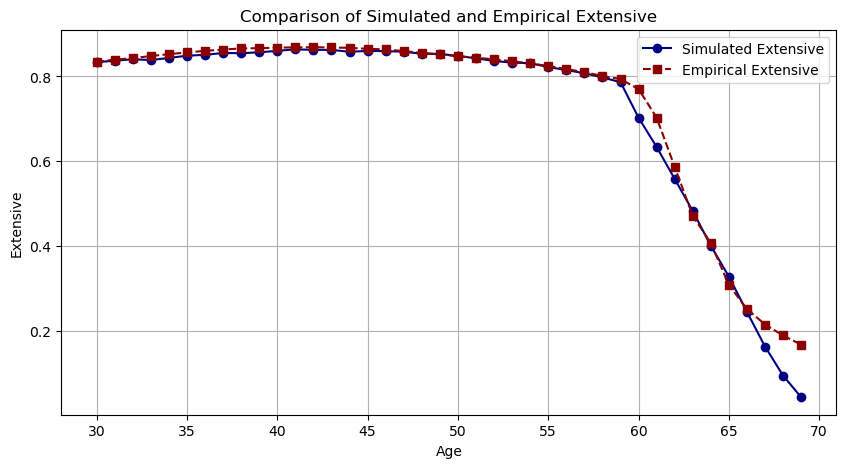

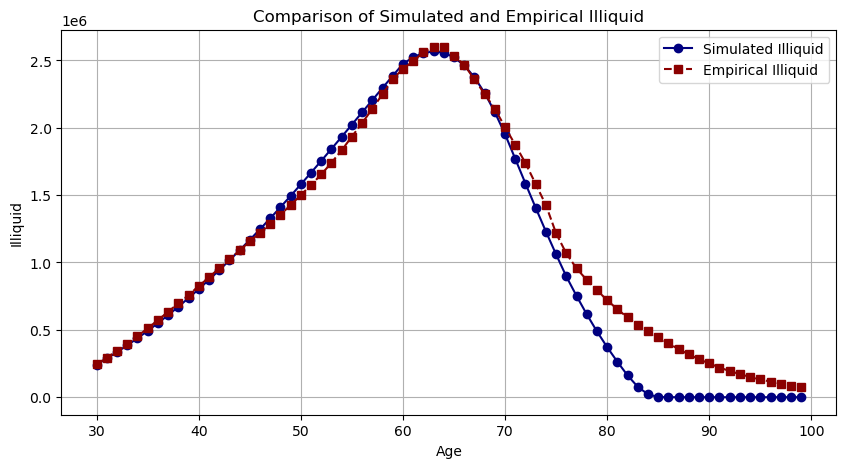

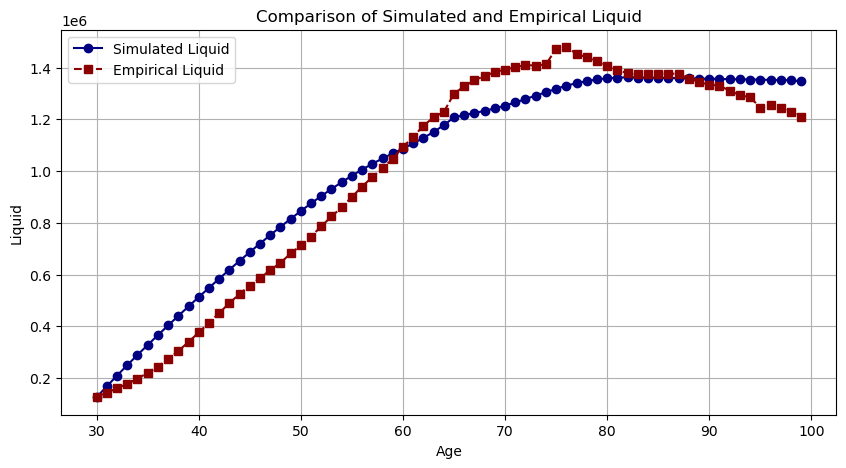

In [10]:
# plot the graph with calibrated values 
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0)[:40], moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40], moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None), moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0), moments['assets']]
}

# Define colors
simulated_color = "navy"  # Dark blue
empirical_color = "darkred"  # Dark red
ci_color = "lightcoral"  # Light red for confidence bands

for key, (simulated, empirical) in a_dict.items():
    plt.figure(figsize=(10, 5))
    
    x_vals = np.arange(len(empirical)) + par.start_age
    
    plt.plot(x_vals, simulated, label=f"Simulated {key.capitalize()}", marker="o", color=simulated_color)
    plt.plot(x_vals, empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s", color=empirical_color)

    # # 99.9% confidence interval
    # ci = std_dev
    # plt.fill_between(x_vals, empirical - ci, empirical + ci, color=ci_color, alpha=0.4, label="Empirical Standard Deviation")

    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()


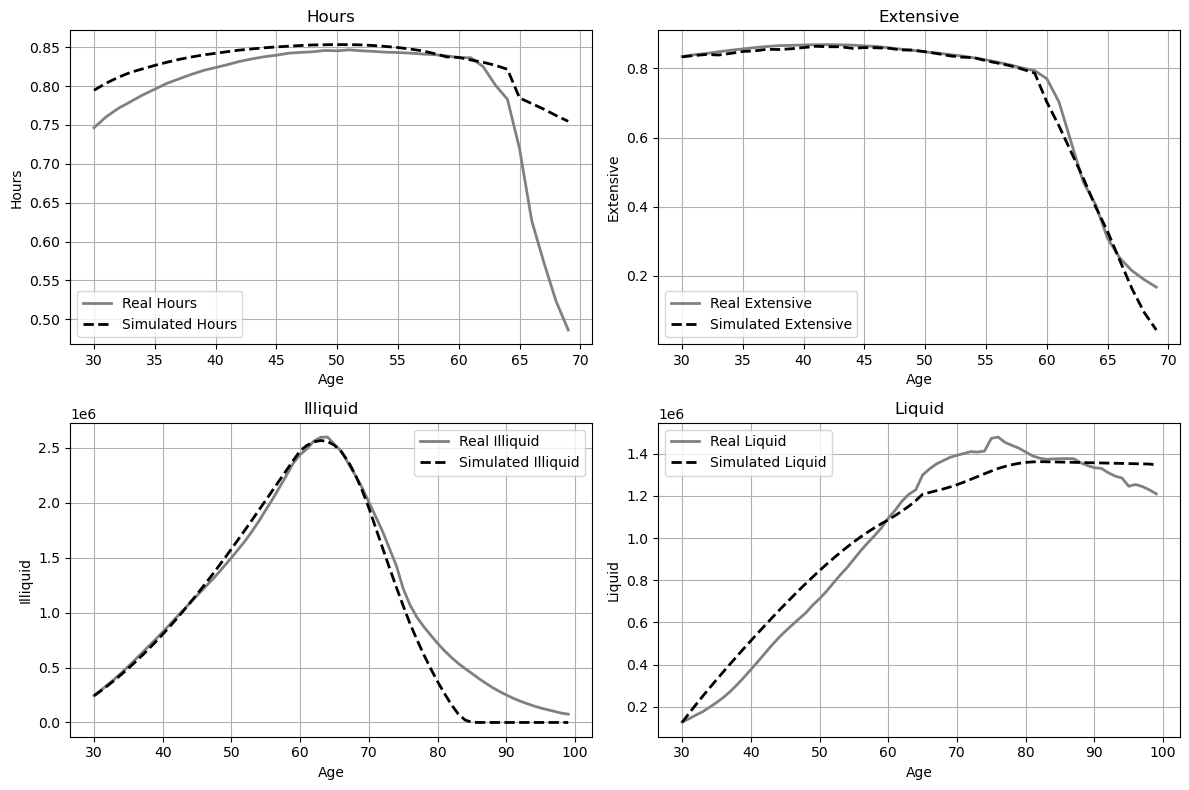

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# prepare your data dict
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:40],
              moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40],
                  moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None),
                 moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0),
               moments['assets']]
}

# set up 2x2 axes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, (key, (sim, emp)) in zip(axes, a_dict.items()):
    x_vals = np.arange(len(emp)) + par.start_age

    # real data: solid grey
    ax.plot(x_vals, emp,
            color='grey',
            linestyle='-',
            linewidth=2,
            label=f"Real {key.capitalize()}")

    # simulated data: darker dashed
    ax.plot(x_vals, sim,
            color='black',
            linestyle='--',
            linewidth=2,
            label=f"Simulated {key.capitalize()}")

    ax.set_xlabel("Age")
    ax.set_ylabel(key.capitalize())
    ax.set_title(key.capitalize())
    ax.grid(True)
    ax.legend()

fig.tight_layout()
plt.show()


Old best variables with variance matrix:

In [11]:
theta_old = ([beta=0.982 sigma=1.210 gamma=2.807 mu=14.881 zeta=3.000 r_a=0.001 r_s=0.025 ])

SyntaxError: invalid syntax (396666488.py, line 1)